<h2>Group 4 Sentiment Analysis</h2>

<h3>When doing the scalability analysis, the code was only to code cell number 3</h3>

In [10]:
import findspark
findspark.init("/home/ubuntu/spark-3.3.2-bin-hadoop3")
findspark.find()

'/home/ubuntu/spark-3.3.2-bin-hadoop3'

In [11]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
 
spark = SparkSession.builder\
        .master("spark://192.168.2.24:7077") \
        .appName("4 Worker")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", True)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.cores.max", 8)\
        .getOrCreate()

In [12]:
#Will by default analyze hate to love ratio. Change the order of the words in "hate_ratio" to get love to hate ratio

q = spark.read.json("hdfs://group4-master:9000/RC_2016-02.json")
q.printSchema()
q.createOrReplaceTempView("comments")
hate_ratio = spark.sql("SELECT subreddit, count(body) as total_bodies, SUM(CASE WHEN lower(body) LIKE '% hate%' THEN 1 ELSE 0 END) / SUM(CASE WHEN lower(body) LIKE '% love%' THEN 1 ELSE 0 END) as hate_ratio FROM comments GROUP BY subreddit ORDER BY hate_ratio DESC")

hr = hate_ratio.createOrReplaceTempView("frequency")
new_var = spark.sql("SELECT * from frequency where total_bodies > 5000 and hate_ratio != 0.0 sort by hate_ratio DESC")
new_var.take(10)

root
 |-- _corrupt_record: string (nullable = true)
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- ups: long (nullable = true)



[Row(subreddit='PoliticalDiscussion', total_bodies=9501, hate_ratio=1.5106382978723405),
 Row(subreddit='news', total_bodies=21579, hate_ratio=1.3768115942028984),
 Row(subreddit='worldnews', total_bodies=24243, hate_ratio=1.1900826446280992),
 Row(subreddit='politics', total_bodies=75892, hate_ratio=1.0358090185676392),
 Row(subreddit='blackops3', total_bodies=7934, hate_ratio=0.937984496124031),
 Row(subreddit='TumblrInAction', total_bodies=5149, hate_ratio=0.9339622641509434),
 Row(subreddit='The_Donald', total_bodies=6840, hate_ratio=0.90625),
 Row(subreddit='leagueoflegends', total_bodies=37358, hate_ratio=0.8397435897435898),
 Row(subreddit='MMA', total_bodies=9482, hate_ratio=0.7945205479452054),
 Row(subreddit='gifs', total_bodies=16672, hate_ratio=0.7876106194690266)]

In [13]:
subreddits = new_var.select("subreddit").take(10)

In [14]:
ratio = new_var.select("hate_ratio").take(10)

/tmp/ipykernel_204504/128788192.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(subreddit_list, rotation=60)


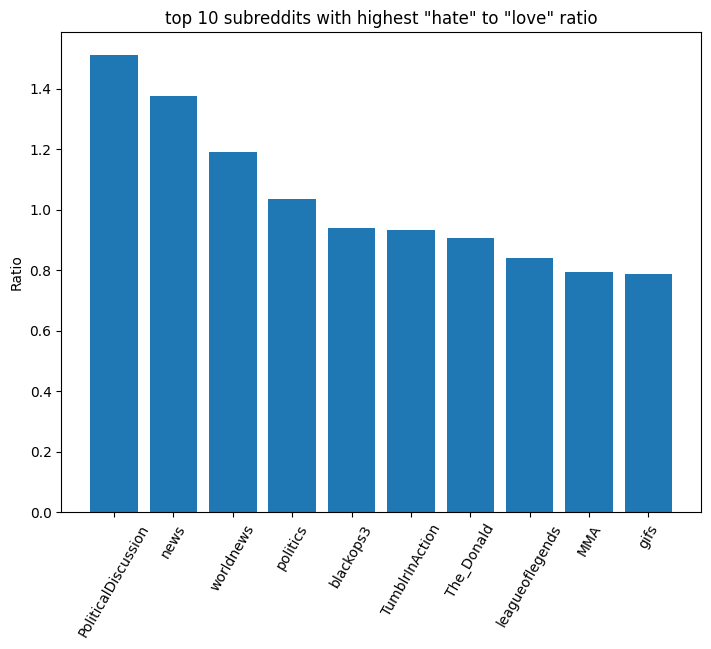

In [15]:
import matplotlib.pyplot as plt

#Plot the results for hate to love ratio

subreddit_list = [row.subreddit for row in subreddits]
ratio_list = [row.hate_ratio for row in ratio]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#langs = ['C', 'C++', 'Java', 'Python', 'PHP']
#students = [23,17,35,29,12]
ax.set_xticklabels(subreddit_list, rotation=60)
ax.bar(subreddit_list, ratio_list)
plt.title('top 10 subreddits with highest "hate" to "love" ratio')
plt.ylabel("Ratio")
plt.show()

/tmp/ipykernel_204504/2379890176.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(subreddit_list, rotation=60)


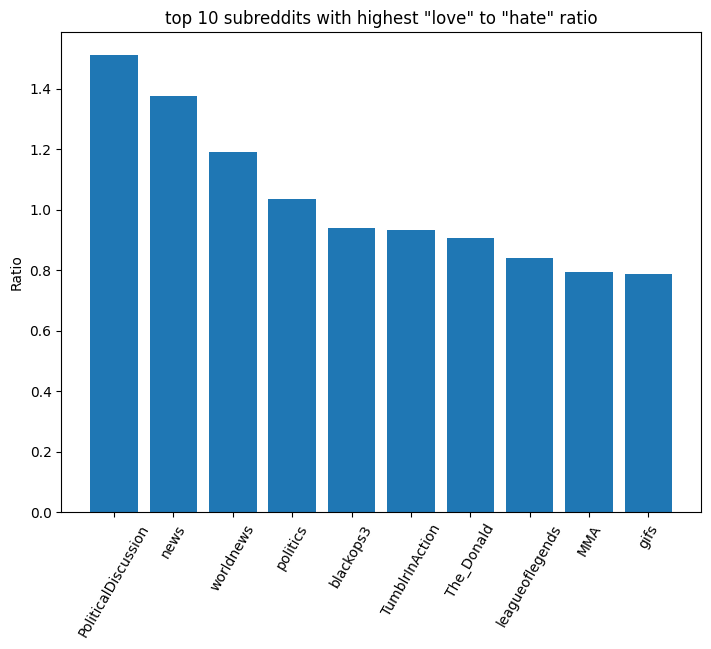

In [16]:
#Plot the results for love to hate ratio

subreddit_list = [row.subreddit for row in subreddits]
ratio_list = [row.hate_ratio for row in ratio]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xticklabels(subreddit_list, rotation=60)
ax.bar(subreddit_list, ratio_list)
plt.title('top 10 subreddits with highest "love" to "hate" ratio')
plt.ylabel("Ratio")
plt.show()

In [17]:
spark.stop()